# Filter

python=3.7

|topic      |platform   |language   |
|-----------|-----------|-----------|
|POTUS2020  |Twitter    |en         |

In [ ]:
import pandas as pd
import seaborn as sns
import re
from joblib import dump, load
from joblib import Parallel, delayed  
from tldextract import extract
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

name_suffix = "[v3][debunking=keywords][lang=en][topic=POTUS2020][platform=Twitter]"

## Screening of posts related to August 18, 2020 - January 20, 2021

In [5]:
import os
import re
from datetime import datetime
import pandas as pd
from multiprocessing import Pool

# keywords
keywords = ["trump", "maga", "MakeAmericaGreatAgain", "Make America Great Again", "sleepy joe", 
            "sleepyjoe", "AmericaFirst", "kag", "pence", "VoteRed2020", 
            "biden", "joe2020", "teamjoe", "kamala", "harris", "demconvention", "demdebate", 
            "BattleForTheSoulOfTheNation", "Battle For The Soul Of The Nation", "VoteBlue2020", 
            "election2020", "elections2020", "debates2020"]

# file path
source_path = "/mnt/data/Project7/fakenews/csv/"
target_path = "data/csv_filtered/"

# set file range
start_num = 13
end_num = 16

# settings for result filename
label = 'en+POTUS2020'
content = 'tweet'

# format of source filename
file_num_pattern = r'(\d+)\.csv'

# other settings
chunksize = 1e6
proc_num = 10

def process_file(source_name):
    # check file name
    mtch = re.search(file_num_pattern, source_name)
    if mtch:
        # get file number from file name
        file_num = int(mtch.group(1))
        
        # check if the date in time range. if yes, process the file.
        if start_num <= file_num <= end_num:
            print(f"processing {source_name} ... ...\n", end='')
            target_name = f"{content}[{label}][{file_num}].csv"

            # check if the target file already exists
            if os.path.exists(target_path + target_name):
                print(f"{target_name} already exists.\n", end='')
                return

            try:
                for chunk in pd.read_csv(source_path + source_name, chunksize=chunksize, low_memory=False):
                    df = chunk[
                            chunk['text'].str.contains('|'.join(keywords), case=False) |
                            chunk['entities.hashtags'].astype(str).str.contains('|'.join(keywords), case=False)
                        ]
                    df.to_csv(target_path + target_name, mode='a', index=False)
                print(f"{source_name} processed.\n", end='')
            except Exception as e:
                print(f"failed processing {source_name}.\n{e}\n", end='')

# # get a list of files
# files = os.listdir(source_path)

# # create a pool of workers
# with Pool(processes=proc_num) as pool:
#     pool.map(process_file, files)

# print("Done.")

In [ ]:

results = []
for i in range(start_num, end_num+1):
    df = pd.read_csv(f"{target_path}{content}[{label}][{i}].csv")
    results.append(df)
results.reverse()
df = pd.concat(results, axis=0)
df.drop_duplicates(subset='id', keep='first', inplace=True)  
df = df[df['lang'] == 'en']  
df.reset_index(drop=True, inplace=True)  

In [ ]:

start_date = pd.to_datetime('2020-8-18T00:00:00.000Z')
end_date = pd.to_datetime('2021-1-21T00:00:00.000Z')
df['created_at'] = pd.to_datetime(df['created_at'])
data = df[(start_date < df['created_at']) & (df['created_at'] < end_date)]
data.to_csv(f"data/full_data{name_suffix}.csv", index=False)

In [9]:
data.loc[:, ['created_at']]

,created_at
478858,2021-01-20 23:59:59+00:00
478859,2021-01-20 23:59:59+00:00
478860,2021-01-20 23:59:58+00:00
478861,2021-01-20 23:59:54+00:00
478862,2021-01-20 23:59:53+00:00
...,...
7087317,2020-08-18 00:00:02+00:00
7087318,2020-08-18 00:00:02+00:00
7087319,2020-08-18 00:00:01+00:00
7087320,2020-08-18 00:00:01+00:00


In [ ]:
# data = pd.read_csv(f"data/full_data{name_suffix}.csv")

authors = set(data[data['author.username'].notna()]['author.username'])

in_reply_to_users = set(data[data['in_reply_to_username'].notna()]['in_reply_to_username'])

retweeted_users = set(data[data['retweeted_username'].notna()]['retweeted_username'])

quoted_users = set(data[data['quoted_username'].notna()]['quoted_username'])

all_users = authors | in_reply_to_users | retweeted_users | quoted_users


print("authors:", len(authors))
print("in_reply_to_users:", len(in_reply_to_users))
print("retweeted_users:", len(retweeted_users))
print("quoted_users:", len(quoted_users))
print("all_users:", len(all_users))

authors: 1463058
in_reply_to_users: 184274
retweeted_users: 74934
quoted_users: 21659
all_users: 1532128


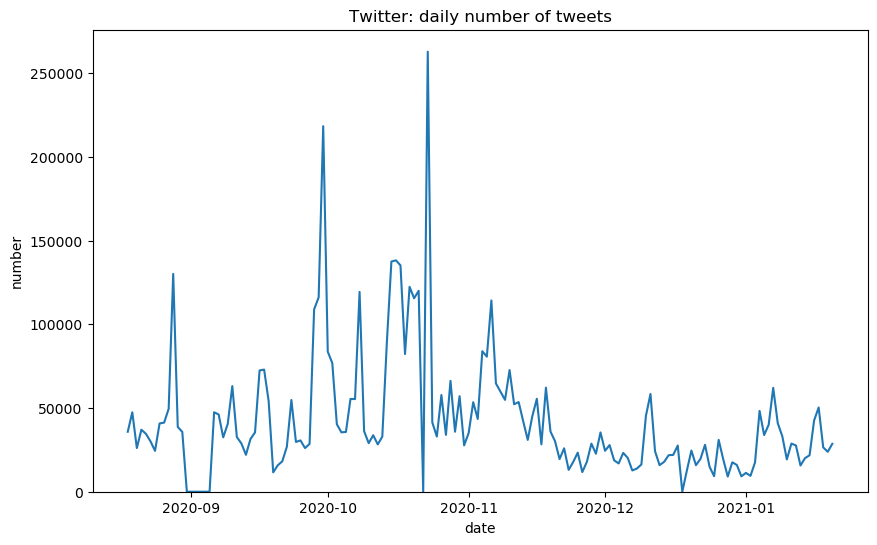

In [ ]:

# df = pd.read_csv(f"data/full_data{name_suffix}.csv")
df = data

df['created_at'] = pd.to_datetime(df['created_at'])
df['date'] = df['created_at'].dt.date  


date_range = pd.date_range(start=df['date'].min(), end=df['date'].max())

daily_counts = df.groupby('date').size()  

daily_counts = daily_counts.reindex(date_range, fill_value=0)

plt.figure(figsize=(10, 6))

sns.lineplot(data=daily_counts)

plt.title('Twitter: daily number of tweets')
plt.ylim((0,None))
plt.xlabel('date')
plt.ylabel('number')
plt.show()